# N-gram

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder

In [ ]:
corpus = [
    "I like deep learning",
    "I like NLP",
    "NLP is very interesting",
    "I love learning NLP",
    "Everyone loves NLP"
]

In [ ]:
tokenized_sentences = [sentence.lower().split() for sentence in corpus]
vocab = sorted(set(word for sentence in tokenized_sentences for word in sentence))
vocab_size = len(vocab)

In [ ]:
# Unigram
unigram_counts = defaultdict(int)
for sentence in tokenized_sentences:
  for word in sentence:
    unigram_counts[word] += 1

In [ ]:
unigram_counts

defaultdict(int,
            {'i': 3,
             'like': 2,
             'deep': 1,
             'learning': 2,
             'nlp': 4,
             'is': 1,
             'very': 1,
             'interesting': 1,
             'love': 1,
             'everyone': 1,
             'loves': 1})

In [ ]:
# Bigram
bigram_counts = defaultdict(lambda: defaultdict(int))
for sentence in tokenized_sentences:
  for i in range(len(sentence) - 1):
    bigram_counts[sentence[i]][sentence[i+1]] += 1

In [ ]:
bigram_counts

defaultdict(<function __main__.<lambda>()>,
            {'i': defaultdict(int, {'like': 2, 'love': 1}),
             'like': defaultdict(int, {'deep': 1, 'nlp': 1}),
             'deep': defaultdict(int, {'learning': 1}),
             'nlp': defaultdict(int, {'is': 1}),
             'is': defaultdict(int, {'very': 1}),
             'very': defaultdict(int, {'interesting': 1}),
             'love': defaultdict(int, {'learning': 1}),
             'learning': defaultdict(int, {'nlp': 1}),
             'everyone': defaultdict(int, {'loves': 1}),
             'loves': defaultdict(int, {'nlp': 1})})

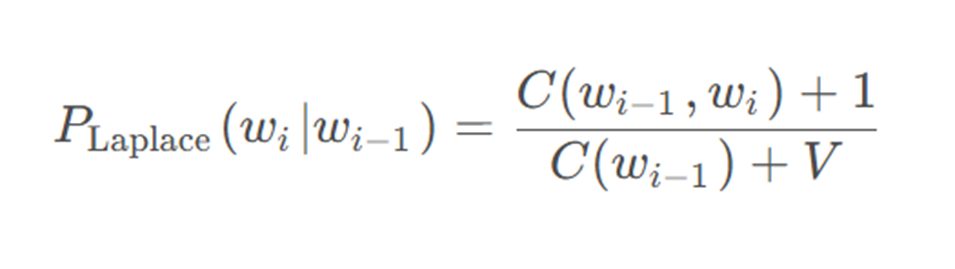

In [ ]:
# Laplace smoothing
def bigram_laplace(w1, w2):
  return (bigram_counts[w1][w2] + 1) / (unigram_counts[w1] + vocab_size)

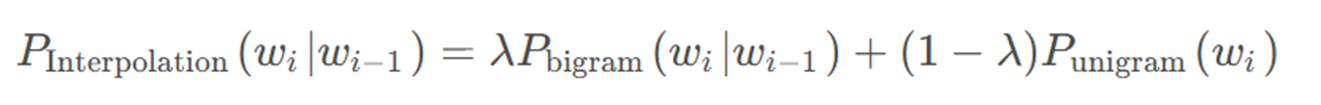

In [ ]:
# Interpolation Smoothing
lambda_bigram = 0.7
lambda_unigram = 1 - lambda_bigram
def bigram_interpolation(w1, w2):
  bigram_prob = bigram_counts[w1][w2] / unigram_counts[w1] if unigram_counts[w1] else 0
  unigram_prob = unigram_counts[w2] / sum(unigram_counts.values())
  return lambda_bigram * bigram_prob + lambda_unigram * unigram_prob

In [ ]:
word1, word2 = "i", "like"
print("Laplace Smoothing Porbability ({}|{}): {:.4f}".format(
    word2, word1, bigram_laplace(word1, word2)
))
print("Interpolation Smoothing Porbability ({}|{}): {:.4f}".format(
    word2, word1, bigram_interpolation(word1, word2)
))

Laplace Smoothing Porbability (like|i): 0.2143
Interpolation Smoothing Porbability (like|i): 0.5000


In [ ]:
word1, word2 = "he", "like"
print("Laplace Smoothing Porbability ({}|{}): {:.4f}".format(
    word2, word1, bigram_laplace(word1, word2)
))
print("Interpolation Smoothing Porbability ({}|{}): {:.4f}".format(
    word2, word1, bigram_interpolation(word1, word2)
))

Laplace Smoothing Porbability (like|he): 0.0909
Interpolation Smoothing Porbability (like|he): 0.0333


# NNLM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
def make_batch():
  input_batch = []
  target_batch = []
  for sen in sentences:
    word = sen.split()
    input = [word_dict[n] for n in word[:-1]]
    target = word_dict[word[-1]]
    input_batch.append(input)
    target_batch.append(target)
  return input_batch, target_batch

In [ ]:
make_batch()

([[6, 3], [6, 5], [6, 1]], [0, 4, 2])

In [ ]:
class NNLM(nn.Module):
  def __init__(self):
    # super().__init__()
    super(NNLM, self).__init__()
    # The embedding layer is defined to convert the lexical index in to a vector representation,
    # where n_class is the vocabulary size and m is the embedding demension
    self.C = nn.Embedding(n_class, m)
    # Define the linear layer to convert the input vector to the hidden laryer representaion
    # where n_step is the context window size, and n_hidden is the size of hidden layer
    self.H = nn.Linear(n_step * m, n_hidden, bias=False)
    # Define the bias vector d of shape [n_hidden]
    self.d = nn.Parameter(torch.ones(n_hidden))
    # Define the linear layer that converts the hidden layer representation to the output
    # n_class is the vocabulary size
    self.U = nn.Linear(n_hidden, n_class, bias=False)
    # Define the linear layer to directly convert input vectors to ouputs
    # similar to residual connections
    self.W = nn.Linear(n_step * m, n_class, bias=False)
    # Define the bias vector b of shape [n_class]
    self.b = nn.Parameter(torch.ones(n_class))

  def forward(self, X):
    # The input X is passed through the embedding layer to obetain the embedding vector
    # shape: [batch_size, n_step, m]
    X = self.C(X)
    # Flattening the embedding vector into a 2-D tensor of shape [batch_size, n_step*m]
    X = X.view(-1, n_step * m)
    # The flattened input is passed through the linear layer H
    # Then activated by tanh with the addition of bias d
    # The shape is [batch_size, n_hidden]
    tanh = torch.tanh(self.d + self.H(X))
    # Pass the input X through the linear layer W,
    # plus the hidden layer output U(tanh) and bias b to get the final output
    # shape: [batch_size, n_class]
    output = self.b + self.W(X) + self.U(tanh)
    return output

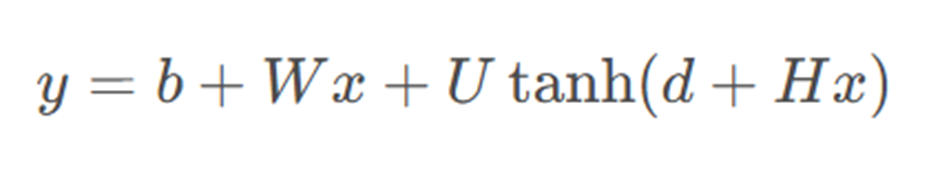

In [ ]:
sentences = [
    "i like dog", "i love coffee", "i hate milk"
]
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)

m = 2
n_step = 2
n_hidden = 2

In [ ]:
model = NNLM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
input_batch, target_batch = make_batch()
input_batch = torch.LongTensor(input_batch)
target_batch = torch.LongTensor(target_batch)

In [ ]:
for epoch in range(5000):
  # Cleaning the historical gradient, avoid accumulation of gradents
  optimizer.zero_grad()
  output = model(input_batch)
  loss = criterion(output, target_batch)
  if (epoch + 1) % 500 == 0:
    print("Epoch: ", "%04d" % (epoch+1), "Loss = ", "{:.6f}".format(loss))
  # Back propagation & calculate gradents
  loss.backward()
  # Update the model's parameters
  optimizer.step()

Epoch:  0500 Loss =  0.001583
Epoch:  1000 Loss =  0.000420
Epoch:  1500 Loss =  0.000190
Epoch:  2000 Loss =  0.000106
Epoch:  2500 Loss =  0.000065
Epoch:  3000 Loss =  0.000043
Epoch:  3500 Loss =  0.000030
Epoch:  4000 Loss =  0.000021
Epoch:  4500 Loss =  0.000015
Epoch:  5000 Loss =  0.000011


In [ ]:
# The prediction is made on the input batch and the class with the highest probability is selected
predict = model(input_batch).data.max(1, keepdim=True)[1]

In [ ]:
print([sen.split()[:2] for sen in sentences], "->", [number_dict[n.item()] for n in predict.squeeze()])

[['i', 'like'], ['i', 'love'], ['i', 'hate']] -> ['dog', 'coffee', 'milk']
